# Introduction to Neural Networks 
Author: Marieme Ngom, adapting materials from Bethany Lusch, Asad Khan, Prasanna Balaprakash, Taylor Childers, Corey Adams, Kyle Felker, and Tanwi Mallick.

This tutorial will serve as a gentle introduction to neural networks and deep learning through a hands-on classification problem using the MNIST dataset. 

In particular, we will introduce neural networks and how to train and improve their learning capabilities.  We will use the PyTorch Python library.

The [MNIST dataset](http://yann.lecun.com/exdb/mnist/) contains thousands of examples of handwritten numbers, with each digit labeled 0-9.
<img src="images/mnist_task.png"  align="left"/>



In [30]:
%matplotlib inline

import torch
import torchvision
from torch import nn

import numpy 
import matplotlib.pyplot as plt
import time

## The MNIST dataset

We will now download the dataset that contains handwritten digits. MNIST is a popular dataset, so we can download it via the PyTorch library. Note:
- x is for the inputs (images of handwritten digits) and y is for the labels or outputs (digits 0-9)
- We are given "training" and "test" datasets. Training datasets are used to fit the model. Test datasets are saved until the end, when we are satisfied with our model, to estimate how well our model generalizes to new data.

Note that downloading it the first time might take some time.
The data is split as follows:
- 60,000 training examples, 10,000 test examples
- inputs: 1 x 28 x 28 pixels
- outputs (labels): one integer per example 

In [31]:
training_data = torchvision.datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

test_data = torchvision.datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

In [32]:
train_size = int(0.8 * len(training_data))  # 80% for training
val_size = len(training_data) - train_size  # Remaining 20% for validation
training_data, validation_data = torch.utils.data.random_split(training_data, [train_size, val_size], generator=torch.Generator().manual_seed(55))

In [33]:
print('MNIST data loaded: train:',len(training_data),' examples, validation: ', len(validation_data), 'examples, test:',len(test_data), 'examples')
print('Input shape', training_data[0][0].shape)

MNIST data loaded: train: 48000  examples, validation:  12000 examples, test: 10000 examples
Input shape torch.Size([1, 28, 28])


Let's take a closer look. Here are the first 10 training digits:

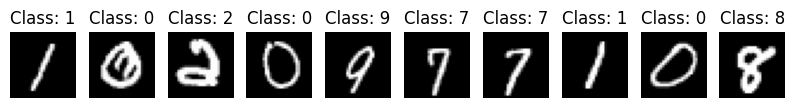

In [34]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(numpy.reshape(training_data[i][0], (28, 28)), cmap="gray")
    plt.title('Class: '+str(training_data[i][1]))

# Generalities:
To train our classifier, we need (besides the data):
- A model that depend on parameters $\mathbf{\theta}$. Here we are going to use neural networks.
- A loss function $J(\mathbf{\theta})$ to measure the capabilities of the model.
- An optimization method.

# Linear Model
Let's begin with a simple linear model: linear regression, like last week. 
We add one complication: each example is a vector (flattened image), so the "slope" multiplication becomes a dot product. If the target output is a vector as well, then the multiplication becomes matrix multiplication. 

Note, like before, we consider multiple examples at once, adding another dimension to the input. 


 <img src="images/LinearModel_1.png"  align="center"/>
 


The linear layers in PyTorch perform a basic $xW + b$. These "fully connected" layers connect each input to each output with some weight parameter. We wouldn't expect a simple linear model $f(x) = xW+b$ directly outputting the class label and minimizing mean squared error to work well - the model would output labels like 3.55 and 2.11 instead of skipping to integers.

We now need:
- A loss function $J(\theta)$ where $\theta$ is the list of parameters (here W and b). Last week, we used mean squared error (MSE), but this week let's make two changes that make more sense for classification:
    - Change the output to be a length-10 vector of class probabilities (0 to 1, adding to 1).
    - Cross entropy as the loss function, which is typical for classification. You can read more [here](https://gombru.github.io/2018/05/23/cross_entropy_loss/). 

- An optimization method or optimizer such as the stochastic gradient descent (sgd) method, the Adam optimizer, RMSprop, Adagrad etc. Let's start with stochastic gradient descent (sgd), like last week. For far more information about more advanced optimizers than basic SGD, with some cool animations, see https://ruder.io/optimizing-gradient-descent/ or https://distill.pub/2017/momentum/.

- A learning rate. As we learned last week, the learning rate controls how far we move during each step. 

In [35]:
class LinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        
        # First, we need to convert the input image to a vector by using 
        # nn.Flatten(). For MNIST, it means the second dimension 28*28 becomes 784.
        self.flatten = nn.Flatten()
        
        # Here, we add a fully connected ("dense") layer that has 28 x 28 = 784 input nodes 
        #(one for each pixel in the input image) and 10 output nodes (for probabilities of each class).
        self.layer_1 = nn.Linear(28*28, 10)
        
    def forward(self, x):

        x = self.flatten(x)
        x = self.layer_1(x)

        return x

In [36]:
linear_model = LinearClassifier()
print(linear_model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(linear_model.parameters(), lr=0.05)

LinearClassifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer_1): Linear(in_features=784, out_features=10, bias=True)
)


# Learning
Now we are ready to train our first model. A training step is comprised of:
- A forward pass: the input is passed through the network
- Backpropagation: A backward pass to compute the gradient $\frac{\partial J}{\partial \mathbf{W}}$ of the loss function with respect to the parameters of the network.
- Weight updates $\mathbf{W} = \mathbf{W} - \alpha \frac{\partial J}{\partial \mathbf{W}} $ where $\alpha$ is the learning rate.

How many steps do we take?
- The batch size corresponds to the number of training examples in one pass (forward + backward). A smaller batch size allows the model to learn from individual examples but takes longer to train. A larger batch size requires fewer steps but may result in the model not capturing the nuances in the data. The higher the batch size, the more memory you will require.  
- An epoch means one pass through the whole training data (looping over the batches). Using few epochs can lead to underfitting and using too many can lead to overfitting.
- The choice of batch size and learning rate are important for performance, generalization and accuracy in deep learning.






In [37]:
batch_size = 128

# The dataloader makes our dataset iterable 
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)

In [38]:
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # backward pass calculates gradients
        loss.backward()
        
        # take one step with these gradients
        optimizer.step()
        
        # resets the gradients 
        optimizer.zero_grad()

In [39]:
def evaluate(dataloader, model, loss_fn):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing 
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:
            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy 
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= num_batches
    correct /= size
    
    accuracy = 100*correct
    return accuracy, loss

In [40]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, linear_model, loss_fn, optimizer)
    
    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, linear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")
    
    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, linear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 0.5025817164580028, accuracy: 87.62083333333334
Epoch 0: val. loss: 0.4946291947618444, val. accuracy: 87.63333333333333
Epoch 1: training loss: 0.4216875925064087, accuracy: 88.9875
Epoch 1: val. loss: 0.412187545540485, val. accuracy: 88.86666666666667
Epoch 2: training loss: 0.3875672733386358, accuracy: 89.6875
Epoch 2: val. loss: 0.37750763097342027, val. accuracy: 89.51666666666667
Epoch 3: training loss: 0.3675444844166438, accuracy: 90.16041666666666
Epoch 3: val. loss: 0.35731362630712227, val. accuracy: 89.97500000000001
Epoch 4: training loss: 0.3539416278998057, accuracy: 90.43333333333334
Epoch 4: val. loss: 0.34372551247794575, val. accuracy: 90.34166666666667
CPU times: user 14min 14s, sys: 357 ms, total: 14min 14s
Wall time: 36.1 s


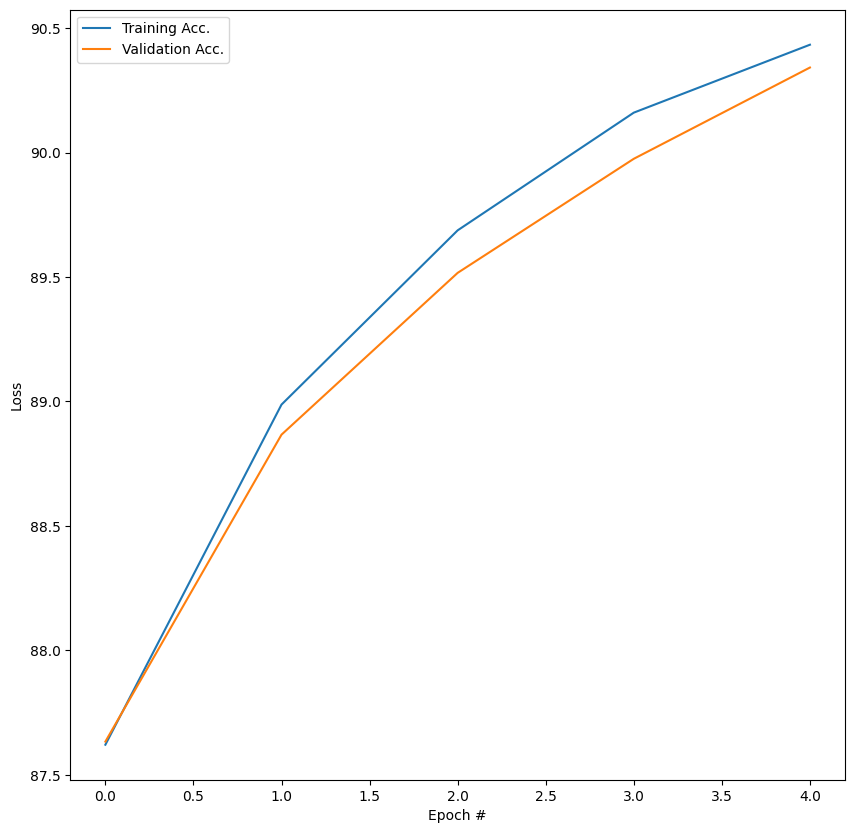

In [41]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

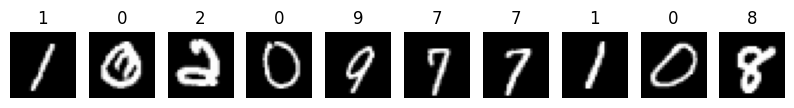

In [42]:
# Visualize how the model is doing on the first 10 examples
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))
linear_model.eval()
batch = next(iter(train_dataloader))
predictions = linear_model(batch[0])

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(batch[0][i,0,:,:], cmap="gray")
    plt.title('%d' % predictions[i,:].argmax())

Exercise: How can you improve the accuracy? Some things you might consider: increasing the number of epochs, changing the learning rate, etc. 

# Prediction

Let's see how our model generalizes to the unseen test data.



In [43]:
#For HW: cell to change batch size
#create dataloader for test data
# The dataloader makes our dataset iterable

batch_size_test = 256 
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

In [44]:
acc_test, loss_test = evaluate(test_dataloader, linear_model, loss_fn)
print("Test loss: %.4f, test accuracy: %.2f%%" % (loss_test, acc_test))

Test loss: 0.3322, test accuracy: 90.85%


We can now take a closer look at the results.

Let's define a helper function to show the failure cases of our classifier.

In [45]:
def show_failures(model, dataloader, maxtoshow=10):
    model.eval()
    batch = next(iter(dataloader))
    predictions = model(batch[0])
    
    rounded = predictions.argmax(1)
    errors = rounded!=batch[1]
    print('Showing max', maxtoshow, 'first failures. '
          'The predicted class is shown first and the correct class in parentheses.')
    ii = 0
    plt.figure(figsize=(maxtoshow, 1))
    for i in range(batch[0].shape[0]):
        if ii>=maxtoshow:
            break
        if errors[i]:
            plt.subplot(1, maxtoshow, ii+1)
            plt.axis('off')
            plt.imshow(batch[0][i,0,:,:], cmap="gray")
            plt.title("%d (%d)" % (rounded[i], batch[1][i]))
            ii = ii + 1

Here are the first 10 images from the test data that this small model classified to a wrong class:



Showing max 10 first failures. The predicted class is shown first and the correct class in parentheses.


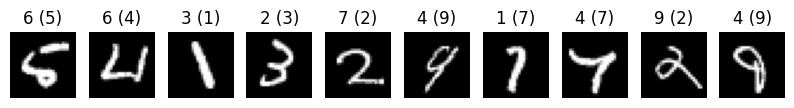

In [46]:
show_failures(linear_model, test_dataloader)

<!-- # Exercise:
- Try changing the loss function,
- Try changing the optimizer -->

# Multilayer Model
Our linear model isn't enough for high accuracy on this dataset. To improve the model, we often need to add more layers and nonlinearities.
<img src="images/shallow_nn.png"  align="left"/>

The output of this NN can be written as
\begin{equation}\label{eq: NN1d}
  \hat{u}(x) = \sigma_2(\sigma_1(\mathbf{x}\mathbf{W}_1 + \mathbf{b}_1)\mathbf{W}_2 + \mathbf{b}_2),
\end{equation}
where $\mathbf{x}$ is the input, $\mathbf{W}_j$ are the weights of the neural network, $\sigma_j$ the (nonlinear) activation functions, and $\mathbf{b}_j$ its biases. The activation function introduces the nonlinearity and makes it possible to learn more complex tasks. Desirable properties in an activation function include being differentiable, bounded, and monotonic.


Image source: [PragatiBaheti](https://www.v7labs.com/blog/neural-networks-activation-functions)
<img src="images/activation.jpeg"  align="center"/>

Adding more layers to obtain a deep neural network:
<img src="images/deep_nn_annotated.jpg"  align="left"/>



# Important things to know
Deep Neural networks can be overly flexible/complicated and "overfit" your data, just like fitting overly complicated polynomials:
<img src="images/bias_vs_variance.png"  align="left"/>


Vizualization wrt to the accuracy and loss (Image source: [Baeldung](https://www.baeldung.com/cs/ml-underfitting-overfitting)):
<img src="images/acc_under_over.webp"  align="center"/>


To improve the generalization of our model on previously unseen data, we employ a technique known as regularization, which constrains our optimization problem in order to discourage complex models.

  - Dropout is the commonly used regularization technique. The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting.
  - Penalizing the loss function by adding a term such as $\lambda ||\mathbf{W}||^2$ is alsp a commonly used regularization technique. This helps "control" the magnitude of the weights of the network.
    
Vanishing gradients: Gradients become small as they propagate backward through the layers. Squashing activation functions like sigmoid or tanh could cause this.

Exploding gradients: Gradients grow exponentially usually due to "poor" weight initialization.

<!--  <img src="images/test_data_rule.png" width="800" hight="500" align="center"/>
  -->

We can now implement a deep network in PyTorch. nn.Dropout() performs the Dropout operation mentioned earlier

In [47]:
#For HW: cell to change activation
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

In [48]:
#### For HW: cell to change learning rate
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.05)

In [49]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)
    
    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")
    
    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 0.8094076910018921, accuracy: 75.15833333333333
Epoch 0: val. loss: 0.8036529250601505, val. accuracy: 75.43333333333334
Epoch 1: training loss: 0.43020360124111173, accuracy: 87.9625
Epoch 1: val. loss: 0.4251215014051884, val. accuracy: 87.8
Epoch 2: training loss: 0.3113919148047765, accuracy: 91.25625000000001
Epoch 2: val. loss: 0.30487453953382815, val. accuracy: 91.4
Epoch 3: training loss: 0.25888907186190285, accuracy: 92.60208333333333
Epoch 3: val. loss: 0.2558614602906907, val. accuracy: 92.45
Epoch 4: training loss: 0.216502367635568, accuracy: 93.90416666666667
Epoch 4: val. loss: 0.21601124829117288, val. accuracy: 93.675
CPU times: user 14min 45s, sys: 532 ms, total: 14min 45s
Wall time: 38.2 s


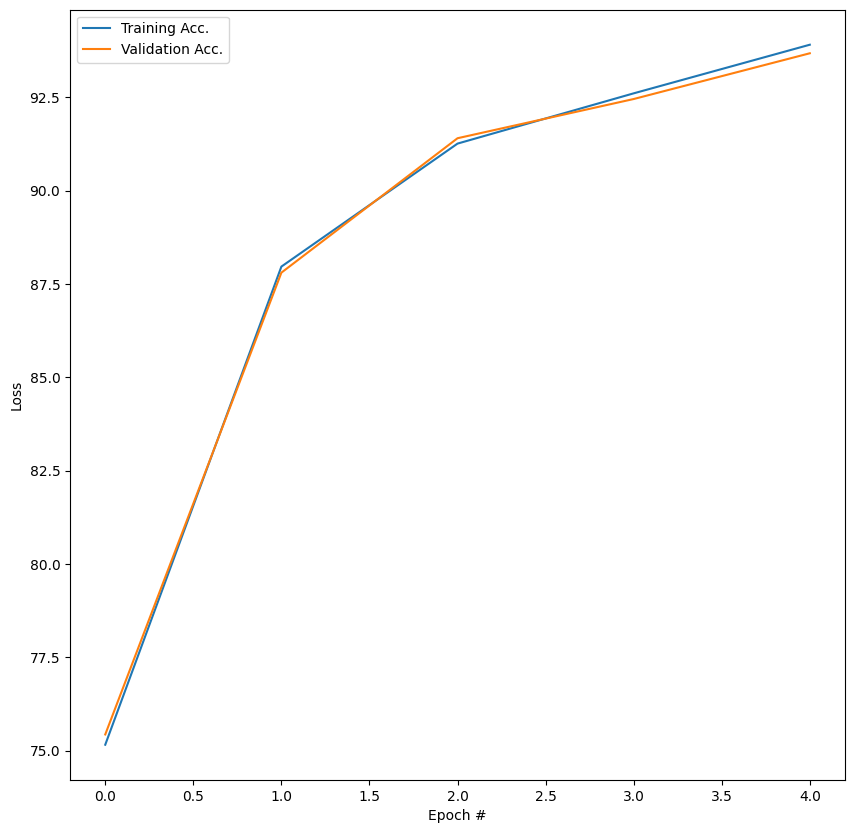

In [50]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

Showing max 10 first failures. The predicted class is shown first and the correct class in parentheses.


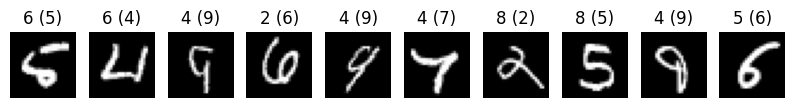

In [51]:
show_failures(nonlinear_model, test_dataloader)

# Recap
To train and validate a neural network model, you need:
- Data split into training/validation/test sets,
- A model with parameters to learn,
- An appropriate loss function,
- An optimizer (with tunable parameters such as learning rate, weight decay etc.) used to learn the parameters of the model.


# Homework

1. Compare the quality of your model when using different:
 - batch sizes, 
 - learning rates,
 - activation functions.

3. Bonus: What is a learning rate scheduler?

If you have time, experiment with how to improve the model. Note: training and validation data can be used to compare models, but test data should be saved until the end as a final check of generalization. 

# Homework solution
Make the following changes to the cells with the comment "#For HW"

In [52]:
#####################To modify the batch size##########################
batch_size = 32 # 64, 128, 256, 512

# The dataloader makes our dataset iterable 
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
##############################################################################


##########################To change the learning rate##########################
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.01) #modify the value of lr
##############################################################################


##########################To change activation##########################
###### Go to https://pytorch.org/docs/main/nn.html#non-linear-activations-weighted-sum-nonlinearity for more activations ######
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.Sigmoid(), #nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.Tanh(), #nn.ReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x
##############################################################################

Bonus question: A learning rate scheduler is an essential deep learning technique used to dynamically adjust the learning rate during training. This strategic can significantly impact the convergence speed and overall performance of a neural network.See below on how to incorporate it to your training.

In [53]:
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.1)

# Step learning rate scheduler: reduce by a factor of 0.1 every 2 epochs (only for illustrative purposes)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

In [54]:
%%time

epochs = 6
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)
    #step the scheduler
    scheduler.step()

    # Print the current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {j+1}/{epochs}, Learning Rate: {current_lr}")
        
    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")
    
    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 1/6, Learning Rate: 0.1
Epoch 0: training loss: 0.36136612422019243, accuracy: 89.15416666666667
Epoch 0: val. loss: 0.350098226527373, val. accuracy: 89.325
Epoch 2/6, Learning Rate: 0.010000000000000002
Epoch 1: training loss: 0.24510824506605666, accuracy: 92.61041666666667
Epoch 1: val. loss: 0.2360366317778826, val. accuracy: 92.59166666666667
Epoch 3/6, Learning Rate: 0.010000000000000002
Epoch 2: training loss: 0.22862798532346884, accuracy: 93.14791666666666
Epoch 2: val. loss: 0.22196514494220415, val. accuracy: 93.175
Epoch 4/6, Learning Rate: 0.0010000000000000002
Epoch 3: training loss: 0.22133048217371107, accuracy: 93.33749999999999
Epoch 3: val. loss: 0.21536836488048236, val. accuracy: 93.44166666666666
Epoch 5/6, Learning Rate: 0.0010000000000000002
Epoch 4: training loss: 0.22068903544048468, accuracy: 93.40416666666667
Epoch 4: val. loss: 0.2148910433501005, val. accuracy: 93.43333333333334
Epoch 6/6, Learning Rate: 0.00010000000000000003
Epoch 5: training loss

## Experimenting with different batch sizes


Training with batch size: 32
Epoch [1/10], Train Loss: 2.2848, Val Loss: 2.2342
Epoch [2/10], Train Loss: 1.9459, Val Loss: 1.4653
Epoch [3/10], Train Loss: 1.1838, Val Loss: 0.8615
Epoch [4/10], Train Loss: 0.8678, Val Loss: 0.6758
Epoch [5/10], Train Loss: 0.7152, Val Loss: 0.5608
Epoch [6/10], Train Loss: 0.6158, Val Loss: 0.4843
Epoch [7/10], Train Loss: 0.5534, Val Loss: 0.4382
Epoch [8/10], Train Loss: 0.5096, Val Loss: 0.4018
Epoch [9/10], Train Loss: 0.4751, Val Loss: 0.3754
Epoch [10/10], Train Loss: 0.4505, Val Loss: 0.3513

Training with batch size: 64
Epoch [1/10], Train Loss: 2.2984, Val Loss: 2.2880
Epoch [2/10], Train Loss: 2.2776, Val Loss: 2.2526
Epoch [3/10], Train Loss: 2.1920, Val Loss: 2.0388
Epoch [4/10], Train Loss: 1.7934, Val Loss: 1.4339
Epoch [5/10], Train Loss: 1.3307, Val Loss: 1.0522
Epoch [6/10], Train Loss: 1.0431, Val Loss: 0.8278
Epoch [7/10], Train Loss: 0.8857, Val Loss: 0.7214
Epoch [8/10], Train Loss: 0.7919, Val Loss: 0.6485
Epoch [9/10], Train L

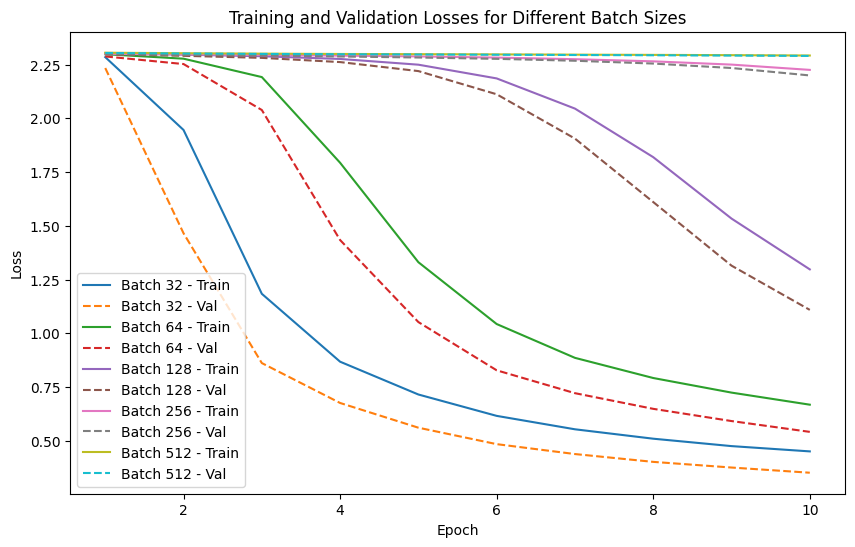

In [55]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Define the number of epochs
num_epochs = 10  # Adjust as needed

# List of batch sizes to experiment with
batch_sizes = [32, 64, 128, 256, 512]

# Store results for plotting
batch_size_results = []

for batch_size in batch_sizes:
    print(f"\nTraining with batch size: {batch_size}")
    
    # Prepare data loaders with the current batch size
    train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
    
    # Initialize the model
    nonlinear_model = NonlinearClassifier()
    
    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(nonlinear_model.parameters(), lr=0.01)
    
    # Lists to store loss values
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # Training phase
        nonlinear_model.train()
        epoch_train_loss = 0
        for inputs, labels in train_dataloader:
            # Move data to device if using GPU
            # inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = nonlinear_model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item()
        
        # Calculate average training loss
        avg_train_loss = epoch_train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        nonlinear_model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for inputs, labels in val_dataloader:
                # inputs, labels = inputs.to(device), labels.to(device)
                outputs = nonlinear_model(inputs)
                loss = criterion(outputs, labels)
                epoch_val_loss += loss.item()
        
        # Calculate average validation loss
        avg_val_loss = epoch_val_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    
    # Store the results for this batch size
    batch_size_results.append({
        'batch_size': batch_size,
        'train_losses': train_losses,
        'val_losses': val_losses
    })

# Plot the training and validation losses for different batch sizes
plt.figure(figsize=(10, 6))
for result in batch_size_results:
    batch_size = result['batch_size']
    epochs = range(1, num_epochs + 1)
    plt.plot(epochs, result['train_losses'], label=f"Batch {batch_size} - Train")
    plt.plot(epochs, result['val_losses'], linestyle='--', label=f"Batch {batch_size} - Val")

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses for Different Batch Sizes')
plt.legend()
plt.show()

## Experimenting with different learning rate


Training with learning rate: 0.001
Epoch [1/10], Train Loss: 2.3049, Val Loss: 2.3032
Epoch [2/10], Train Loss: 2.3029, Val Loss: 2.3014
Epoch [3/10], Train Loss: 2.3010, Val Loss: 2.2999
Epoch [4/10], Train Loss: 2.3000, Val Loss: 2.2986
Epoch [5/10], Train Loss: 2.2989, Val Loss: 2.2974
Epoch [6/10], Train Loss: 2.2977, Val Loss: 2.2963
Epoch [7/10], Train Loss: 2.2967, Val Loss: 2.2953
Epoch [8/10], Train Loss: 2.2957, Val Loss: 2.2942
Epoch [9/10], Train Loss: 2.2947, Val Loss: 2.2930
Epoch [10/10], Train Loss: 2.2935, Val Loss: 2.2918

Training with learning rate: 0.01
Epoch [1/10], Train Loss: 2.3025, Val Loss: 2.2920
Epoch [2/10], Train Loss: 2.2832, Val Loss: 2.2618
Epoch [3/10], Train Loss: 2.2074, Val Loss: 2.0748
Epoch [4/10], Train Loss: 1.8786, Val Loss: 1.5652
Epoch [5/10], Train Loss: 1.4397, Val Loss: 1.1819
Epoch [6/10], Train Loss: 1.1249, Val Loss: 0.8962
Epoch [7/10], Train Loss: 0.9422, Val Loss: 0.7758
Epoch [8/10], Train Loss: 0.8374, Val Loss: 0.6956
Epoch [9/1

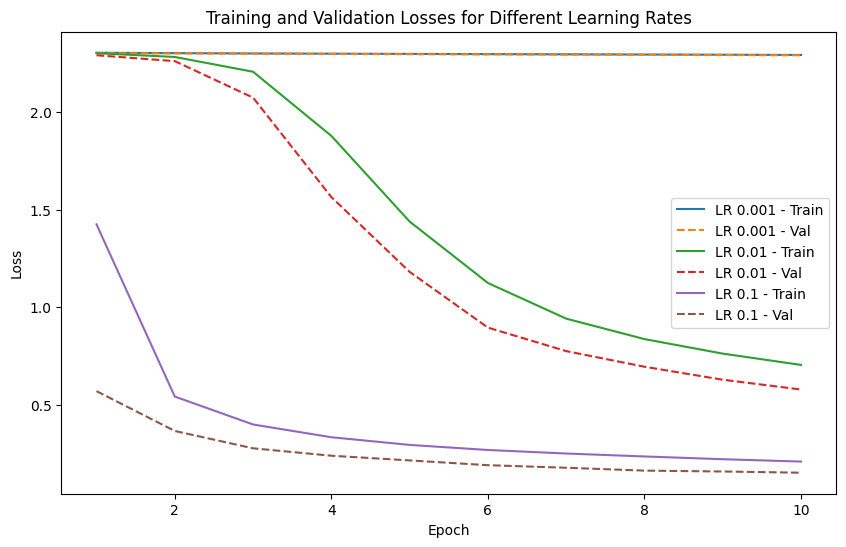

In [56]:
# List of learning rates to experiment with
learning_rates = [0.001, 0.01, 0.1]

# Store results for plotting
learning_rate_results = []

for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr}")
    
    # Use a fixed batch size
    batch_size = 64
    train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
    
    # Initialize the model
    nonlinear_model = NonlinearClassifier()
    
    # Define the loss function and optimizer with the current learning rate
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(nonlinear_model.parameters(), lr=lr)
    
    # Lists to store loss values
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # Training phase
        nonlinear_model.train()
        epoch_train_loss = 0
        for inputs, labels in train_dataloader:
            # Move data to device if using GPU
            # inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = nonlinear_model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item()
        
        # Calculate average training loss
        avg_train_loss = epoch_train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        nonlinear_model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for inputs, labels in val_dataloader:
                # inputs, labels = inputs.to(device), labels.to(device)
                outputs = nonlinear_model(inputs)
                loss = criterion(outputs, labels)
                epoch_val_loss += loss.item()
        
        # Calculate average validation loss
        avg_val_loss = epoch_val_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    
        
    # Store the results for this learning rate
    learning_rate_results.append({
        'learning_rate': lr,
        'train_losses': train_losses,
        'val_losses': val_losses
    })

# Plot the results
plt.figure(figsize=(10, 6))
for result in learning_rate_results:
    lr = result['learning_rate']
    epochs = range(1, num_epochs + 1)
    plt.plot(epochs, result['train_losses'], label=f"LR {lr} - Train")
    plt.plot(epochs, result['val_losses'], linestyle='--', label=f"LR {lr} - Val")

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses for Different Learning Rates')
plt.legend()
plt.show()

## Experimeting with different activation function 

In [57]:
class NonlinearClassifier(nn.Module):

    def __init__(self, activation_function):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            activation_function,
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            activation_function,
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            activation_function,
            nn.Dropout(0.2),
            nn.Linear(50, 10)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)
        return x


Training with activation function: ReLU
Epoch [1/10], Train Loss: 2.2832, Val Loss: 2.2383
Epoch [2/10], Train Loss: 1.9980, Val Loss: 1.4342
Epoch [3/10], Train Loss: 1.2906, Val Loss: 0.9058
Epoch [4/10], Train Loss: 1.0002, Val Loss: 0.7140
Epoch [5/10], Train Loss: 0.8380, Val Loss: 0.5882
Epoch [6/10], Train Loss: 0.7237, Val Loss: 0.4900
Epoch [7/10], Train Loss: 0.6350, Val Loss: 0.4166
Epoch [8/10], Train Loss: 0.5580, Val Loss: 0.3602
Epoch [9/10], Train Loss: 0.5073, Val Loss: 0.3238
Epoch [10/10], Train Loss: 0.4631, Val Loss: 0.2950

Training with activation function: Sigmoid
Epoch [1/10], Train Loss: 2.3112, Val Loss: 2.3012
Epoch [2/10], Train Loss: 2.3097, Val Loss: 2.3008
Epoch [3/10], Train Loss: 2.3105, Val Loss: 2.3007
Epoch [4/10], Train Loss: 2.3080, Val Loss: 2.3008
Epoch [5/10], Train Loss: 2.3077, Val Loss: 2.3009
Epoch [6/10], Train Loss: 2.3061, Val Loss: 2.3010
Epoch [7/10], Train Loss: 2.3062, Val Loss: 2.3006
Epoch [8/10], Train Loss: 2.3060, Val Loss: 2.3

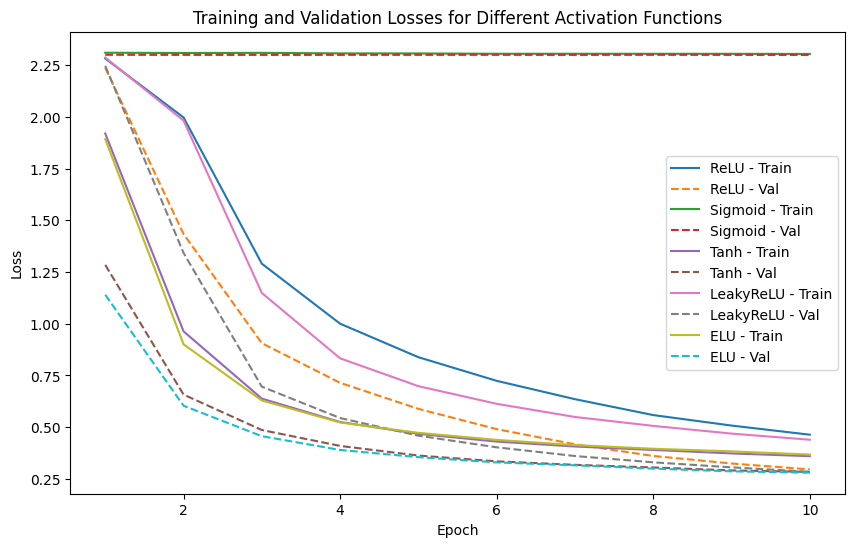

In [58]:
# Dictionary of activation functions to experiment with
activation_functions = {
    'ReLU': nn.ReLU(),
    'Sigmoid': nn.Sigmoid(),
    'Tanh': nn.Tanh(),
    'LeakyReLU': nn.LeakyReLU(),
    'ELU': nn.ELU()
}

# Store results for plotting
activation_results = []

for name, activation in activation_functions.items():
    print(f"\nTraining with activation function: {name}")
    
    # Initialize the model with the current activation function
    nonlinear_model = NonlinearClassifier(activation_function=activation)
    
    # Use fixed batch size and learning rate
    batch_size = 64
    lr = 0.01
    train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
    
    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(nonlinear_model.parameters(), lr=lr)
    
    # Lists to store loss values
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # Training phase
        nonlinear_model.train()
        epoch_train_loss = 0
        for inputs, labels in train_dataloader:
            # Move data to device if using GPU
            # inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = nonlinear_model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item()
        
        # Calculate average training loss
        avg_train_loss = epoch_train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        nonlinear_model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for inputs, labels in val_dataloader:
                # inputs, labels = inputs.to(device), labels.to(device)
                outputs = nonlinear_model(inputs)
                loss = criterion(outputs, labels)
                epoch_val_loss += loss.item()
        
        # Calculate average validation loss
        avg_val_loss = epoch_val_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    
    
    # Store the results for this activation function
    activation_results.append({
        'activation': name,
        'train_losses': train_losses,
        'val_losses': val_losses
    })

# Plot the results
plt.figure(figsize=(10, 6))
for result in activation_results:
    activation = result['activation']
    epochs = range(1, num_epochs + 1)
    plt.plot(epochs, result['train_losses'], label=f"{activation} - Train")
    plt.plot(epochs, result['val_losses'], linestyle='--', label=f"{activation} - Val")

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses for Different Activation Functions')
plt.legend()
plt.show()